In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install lifelines
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
import polars as pl
from datetime import date ,timedelta, datetime
from typing import Dict,List,Optional,Tuple

import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
import lifelines
from lifelines import WeibullFitter, LogNormalFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.calibration import survival_probability_calibration
from datetime import datetime
from lifelines import CoxTimeVaryingFitter
from sklearn.metrics import brier_score_loss
# Input data files are available in the read-only "../data/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from lifelines import CoxTimeVaryingFitter
from lifelines.fitters import UnivariateFitter
import os
for dirname, _, filenames in os.walk('/home/aveleyra/Documentos/mlops-exercise-walmart/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
warnings.filterwarnings("ignore")


pl.Config.set_tbl_cols(15)
pl.Config.set_tbl_rows(50)


/home/aveleyra/Documentos/mlops-exercise-walmart/data/PdM_machines.csv
/home/aveleyra/Documentos/mlops-exercise-walmart/data/PdM_errors.csv
/home/aveleyra/Documentos/mlops-exercise-walmart/data/PdM_telemetry.csv
/home/aveleyra/Documentos/mlops-exercise-walmart/data/PdM_failures.csv
/home/aveleyra/Documentos/mlops-exercise-walmart/data/PdM_maint.csv


polars.config.Config

## What this notebook will cover

### 1📚.
**A Brief (but Actually Useful) Theoretical Overview**   
The Survival/Hazard Function
What it is and why it matters.

Traditional Cox Proportional Hazards Model
Assumes covariates stay constant which can be cute for life science applications, but lacking for incorporating **IoT** signals.

Time Varying Cox PH Models
Let’s get real: sensors update all the time. This model actually handles that.

### 2. 🔍  
**Exploratory Data Analysis: Know Your Machines**   
Using the Microsoft Azure Predictive Maintenance Dataset (1 year of telemetry for 100 devices and 4 components), we’ll:

Look at failure counts by component

Look at distributions of failure times

Show how certain patterns precede failure   

Analyze some survival/reliability and hazard curves using the **Weibull** distribtuion

### 3. 🛠
**Feature Engineering in Polars**   
Show how to manipulate raw telemetry efficiently

Set up long-format data for time-varying Cox models

Calculate anomalous signals per component using telemetry signals and 21-Day rolling Z statistic

### 4. 🧪
**Model Training and Evaluation**   
Train a separate Cox Time-Varying model for each component
(using data from the first half of the year)

Output: daily probability of failure over the next 48 hours

Test performance on the second half of the year

### 5. 📈
**Results and Visualizations**   
Talk about interpretability: why you actually want this vs. a black box

Plot example of telemetry signals and evolution of failure probabilities on validation data set   

### 6. 🚀
**How to Deploy This in the Real World**   
Maintenance teams can use this for daily triage

Works across manufacturing, fleet management, IoT settings

Example: pipe this into a dashboard, set threshold alerts, and watch operations chill out



In [2]:
def box_and_strip(
    df: pd.DataFrame,
    x: str,
    y: str,
    figsize: Tuple[int, int] = (15, 5),
    alpha: float = 0.3,
    title: str = ""
) -> None:
    """
    Create a combined boxplot and stripplot for visualizing the distribution
    of a numeric variable across groups.

    Args:
        df (pd.DataFrame): Input DataFrame containing the data.
        x (str): Column name for the categorical/grouping variable.
        y (str): Column name for the numeric variable to plot.
        figsize (Tuple[int, int], optional): Size of the figure. Defaults to (15, 5).
        alpha (float, optional): Transparency for the boxplot. Defaults to 0.3.
        title (str, optional): Plot title. Defaults to "".

    Returns:
        None. Displays the plot.
    """
    plt.figure(figsize=figsize)
    sns.boxplot(data=df, x=x, y=y, showcaps=True, boxprops=dict(alpha=alpha), showfliers=False)
    sns.stripplot(data=df, x=x, y=y, color='black', size=3.5, jitter=True)

    plt.title(title)
    plt.tight_layout()
    plt.show()


def univariate_survival_model_fitter(
    df: pd.DataFrame,
    model: UnivariateFitter,
    duration_col: str,
    observed_col: str,
    label: str = ""
) -> UnivariateFitter:
    """
    Fit a univariate survival model to time-to-event data.

    Args:
        df (pd.DataFrame): DataFrame containing survival data.
        model (UnivariateFitter): A lifelines univariate survival model instance.
        duration_col (str): Column name representing durations or time-to-event.
        observed_col (str): Column name representing the event indicator (1=event, 0=censored).
        label (str, optional): Label for the fitted model. Defaults to "".

    Returns:
        UnivariateFitter: The fitted lifelines survival model.
    """
    durations = df[duration_col]
    event_observed = df[observed_col]
    return model.fit(durations=durations, event_observed=event_observed, label=label)


def create_survival_model_dict(
    fail_flag_df: pl.DataFrame,
    model: type[CoxTimeVaryingFitter],
    group_level_col: str,
    duration_col: str,
    observe_col: str
) -> Dict[str, CoxTimeVaryingFitter]:
    """
    Create a dictionary of fitted survival models for each group in the data.

    Args:
        fail_flag_df (pl.DataFrame): Polars DataFrame containing grouped survival data.
        model (type[CoxTimeVaryingFitter]): Survival model class (e.g., CoxTimeVaryingFitter).
        group_level_col (str): Column name representing group membership.
        duration_col (str): Column name for durations/time-to-event.
        observe_col (str): Column name for event indicator (1=event, 0=censored).

    Returns:
        Dict[str, CoxTimeVaryingFitter]: Dictionary mapping group name to fitted survival model.
    """
    model_dict: Dict[str, CoxTimeVaryingFitter] = {}
    for group in fail_flag_df.to_pandas()[group_level_col].unique():
        group_df = fail_flag_df.filter(pl.col(group_level_col) == group).to_pandas()
        model_dict[group] = univariate_survival_model_fitter(
            df=group_df,
            model=model(),
            duration_col=duration_col,
            observed_col=observe_col,
            label=group
        )
    return model_dict


def survival_hazard_group_plotter(
    model_dict: Dict[str, UnivariateFitter],
    model_name: str = ""
) -> None:
    """
    Plot survival and hazard functions for a dictionary of fitted survival models.

    Args:
        model_dict (Dict[str, UnivariateFitter]): Dictionary mapping group labels to fitted lifelines models.
        model_name (str, optional): Name of the survival model to include in titles. Defaults to "".

    Returns:
        None. Displays the plots.
    """
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    for group, model in model_dict.items():
        model.plot_survival_function(ax=ax[0])
        ax[0].set_title(f'Reliability Function {model_name}')
        ax[0].set_xlabel('Time (Days)')
        ax[0].set_ylabel('Survival Probability')

        model.plot_hazard(ax=ax[1])
        ax[1].set_title(f'Hazard Function {model_name}')
        ax[1].set_xlabel('Time (Days)')
        ax[1].set_ylabel('Hazard')

    plt.tight_layout()
    plt.show()


def create_time_between_fail_group_df(
    fail_flag_df: pl.DataFrame,
    window_cols: List[str],
    max_datetime: pd.Timestamp
) -> pl.DataFrame:
    """
    Compute time between maintenance/failure events grouped by specified columns.

    Args:
        fail_flag_df (pl.DataFrame): Input Polars DataFrame containing datetime and fail_flag columns.
        window_cols (List[str]): Columns to group over (e.g., ['machineID', 'comp']).
        max_datetime (pd.Timestamp): Maximum timestamp used to fill null end times.

    Returns:
        pl.DataFrame: DataFrame with columns for next replacement time and time between maintenance.
    """
    time_between_fail_group_df = (
        fail_flag_df
        .with_columns([
            pl.col("datetime")
            .shift(-1)
            .over(window_cols)
            .alias("next_replace_time"),

            pl.col("fail_flag")
            .shift(-1)
            .over(window_cols)
            .fill_null(0)
        ])
        .with_columns([
            pl.col("next_replace_time").fill_null(max_datetime),
            (pl.col("next_replace_time") - pl.col("datetime"))
            .dt.total_days()
            .alias("time_between_maintenance")
        ])
        .filter(pl.col("time_between_maintenance") > 0)
    )
    return time_between_fail_group_df


def plot_timeseries_stacked(
    df: pd.DataFrame,
    sensors: List[str],
    time_col: str = "date",
    machine_id: Optional[int] = None
) -> None:
    """
    Plot stacked time series of sensor readings with annotated failure, maintenance, and error events.

    Args:
        df (pd.DataFrame): Input DataFrame containing sensor values and event flags.
        sensors (List[str]): List of sensor column names to plot.
        time_col (str, optional): Column name representing time. Defaults to "date".
        machine_id (Optional[int], optional): Machine ID to filter data. Defaults to None.

    Returns:
        None. Displays the stacked plots with event annotations.
    """
    n = len(sensors)
    if machine_id is not None and "machineID" in df.columns:
        df = df[df["machineID"] == machine_id]

    fig, axes = plt.subplots(n, 1, figsize=(12, 2.5 * n), sharex=True)
    if n == 1:
        axes = [axes]

    event_styles = {
        "error": {
            "columns": ["error1", "error2", "error3", "error4", "error5"],
            "colors": ["orange", "blueviolet", "brown", "firebrick", "violet"],
            "linestyle": "dotted"
        },
        "failure": {
            "columns": ["comp1_failure", "comp2_failure", "comp3_failure", "comp4_failure"],
            "colors": ["red", "green", "black", "blue"],
            "linestyle": "solid"
        },
        "maintenance": {
            "columns": ["comp1", "comp2", "comp3", "comp4"],
            "colors": ["red", "green", "black", "blue"],
            "linestyle": "dashed"
        }
    }

    for i, sensor in enumerate(sensors):
        ax = axes[i]
        sns.lineplot(data=df, x=time_col, y=sensor, ax=ax)
        ax.set_title(sensor.replace("_", " ").title())
        ax.set_ylabel("")
        ax.grid(True)

        for event_type, style in event_styles.items():
            for column, color in zip(style["columns"], style["colors"]):
                times = df.loc[df[column] == 1, time_col]
                for t in times:
                    ax.axvline(t, color=color, linestyle=style["linestyle"], alpha=0.6)

    legend_lines = []
    for event_type in ["failure", "maintenance", "error"]:  # ensure desired order
        style = event_styles[event_type]
        for column, color in zip(style["columns"], style["colors"]):
            label = column.replace("_", " ")
            legend_lines.append(Line2D([0], [0], color=color, linestyle=style["linestyle"],
                                       alpha=0.6, label=label))

    axes[0].legend(handles=legend_lines, loc="upper left", ncol=1,
                   bbox_to_anchor=(1.01, 0), title="Telemetry Event Legend")
    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()


def get_failures_by_comp(
    df_fail: pl.DataFrame,
    machine_id: int,
    comp: str
) -> pl.DataFrame:
    """
    Filter failure records for a specific machine and component.

    Args:
        df_fail (pl.DataFrame): Polars DataFrame containing failure data.
        machine_id (int): Machine identifier to filter by.
        comp (str): Component name to filter by.

    Returns:
        pl.DataFrame: Filtered DataFrame containing failures for the given machine and component.
    """
    return df_fail.filter(pl.col("machineID") == machine_id).filter(pl.col("comp") == comp)


def _lookup_baseline_ch(
    t: float,
    fitted_cox_model: CoxTimeVaryingFitter
) -> float:
    """
    Lookup baseline cumulative hazard value at time t from a fitted Cox model.

    Args:
        t (float): Time point.
        fitted_cox_model (CoxTimeVaryingFitter): Fitted Cox time-varying model.

    Returns:
        float: Baseline cumulative hazard at time t.
    """
    if pd.isna(t):
        return 0.0
    baseline_ch = fitted_cox_model.baseline_cumulative_hazard_
    valid_times = baseline_ch.index[baseline_ch.index <= t]
    if valid_times.empty:
        return 0.0
    return baseline_ch.loc[valid_times.max()].iloc[0]


def predict_failure_proba(
    df: pd.DataFrame,
    ctv_model: CoxTimeVaryingFitter,
    end_col: str = "end",
    n_digits: int = 2
) -> np.ndarray:
    """
    Predict failure probabilities using a Cox time-varying model.

    Args:
        df (pd.DataFrame): DataFrame containing covariates and time columns.
        ctv_model (CoxTimeVaryingFitter): Fitted Cox time-varying model.
        end_col (str, optional): Column name representing the stop time of each interval. Defaults to "end".
        n_digits (int, optional): Number of decimal places to round probabilities. Defaults to 2.

    Returns:
        np.ndarray: Predicted failure probabilities.
    """
    data_baseline_ch = df[end_col].apply(lambda t: _lookup_baseline_ch(t, ctv_model))
    partial_hazard = ctv_model.predict_partial_hazard(df)
    return np.round(1 - np.exp(-data_baseline_ch * partial_hazard), n_digits)


def get_component_failure(
    df: pd.DataFrame
) -> pd.Series:
    """
    Determine whether each component instance has experienced a failure.

    Args:
        df (pd.DataFrame): Pandas DataFrame containing component failure records.
            Must include:
              - "component_instance_id": unique component identifier
              - "component_failure": binary flag (1=failed, 0=not failed)

    Returns:
        pd.Series: Boolean Series indexed by component_instance_id, indicating
                   whether each component has ever failed.
    """
    fail_flag_series = df.groupby("component_instance_id")["component_failure"].any()
    return fail_flag_series


def create_train_calibration_test_dfs(
    df: pl.DataFrame,
    train_stop_date: str,
    calibration_stop_date: str
) -> Tuple[pl.DataFrame, pl.DataFrame, pl.DataFrame]:
    """
    Split a Polars DataFrame into train, calibration, and test sets
    based on stop dates.

    Args:
        df (pl.DataFrame): Polars DataFrame with a "date" column.
        train_stop_date (str): Cutoff date for training set (exclusive).
        calibration_stop_date (str): Cutoff date for calibration set (exclusive).

    Returns:
        Tuple[pl.DataFrame, pl.DataFrame, pl.DataFrame]:
            - train_df: Data before train_stop_date
            - calibration_df: Data between train_stop_date and calibration_stop_date (inclusive left)
            - test_df: Data after calibration_stop_date
    """
    train_df = df.filter(pl.col("date") < train_stop_date)
    calibration_df = df.filter(pl.col("date").is_between(train_stop_date, calibration_stop_date, closed="left"))
    test_df = df.filter(pl.col("date") > calibration_stop_date)
    return train_df, calibration_df, test_df


def round_to_nearest_05_array(
    arr: np.ndarray
) -> np.ndarray:
    """
    Round numeric values to the nearest 0.05.

    Args:
        arr (np.ndarray): Input array of numeric values.

    Returns:
        np.ndarray: Array with values rounded to nearest 0.05.
    """
    return np.round(arr * 20) / 20


def event_pivoter(
    df: pl.DataFrame,
    col: str
) -> pl.DataFrame:
    """
    Pivot event data into wide format, marking occurrences per machine and date.

    Args:
        df (pl.DataFrame): Polars DataFrame containing at least:
            - "datetime": timestamp of event
            - "machineID": machine identifier
            - col (str): event category column to pivot
        col (str): Column to pivot into indicator variables.

    Returns:
        pl.DataFrame: Pivoted DataFrame with one row per (date, machineID),
                      and binary event indicator columns for each value in `col`.
    """
    return (
        df.with_columns(
            [
                pl.col("datetime").dt.date().alias("date"),
                pl.lit(1).alias(f"{col}_event")
            ]
        )
        .pivot(
            values=f"{col}_event",
            index=["date", "machineID"],
            columns=col,
            aggregate_function="first",
            sort_columns=True
        )
        .fill_null(0)
    )
def create_train_test_df(df:pl.DataFrame, split_date,telemetry_columns:list,strategy:str = "mean",shift_telem_days:int=2):
    """
    This method splits the dataset into a train test split.
    Because this is a predictive maintenace application, the training data shifts the
    telemetry column forward two days to align with the needs of the use case. i.e. predict machine
    failure with telemetry data from previous days. In the test dataset the telemetry data is not shifted
    because Iare looking for the signal to provide an early warning of machine failure.
    """
    train_df = (df
             .filter(pl.col("date") < split_date)
             .sort(["component_instance_id","date"])
             .with_columns([
                  pl.col(telemetry_col)
                 .shift(shift_telem_days)
                 .over("component_instance_id")
                 .fill_null(strategy=strategy)
                 for telemetry_col in telemetry_columns
             ]
               )
               )

    test_df = df.filter(pl.col("date") > split_date)
    return train_df, test_df

def plot_top_cox_predictors(model, top_n: int = 20, title: str = "Top Predictors of Hazard (Cox Coefficients)"):
    """
    Plots the top N most significant predictors from a fitted Cox model.

    Parameters:
    - model: Fitted lifelines CoxTimeVaryingFitter or CoxPHFitter
    - top_n: Number of top predictors to display (ranked by lowest p-value)
    - title: Plot title
    """
    summary = model.summary.sort_values("p")
    top = summary.head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(top.index[::-1], top['coef'][::-1], xerr=top['se(coef)'][::-1])
    plt.axvline(0, color='black', linestyle='--')
    plt.title(title)
    plt.xlabel("Coefficient (log hazard ratio)")
    plt.tight_layout()
    plt.show()

## Theoretical Background🧠  

Survival analysis has its roots in the life sciences, think clinical trials and patient follow-ups, but like all good ideas, it didn’t stay in its lane. Over time, these **“Survival Analysis”** methods found their way into fields like manufacturing, finance, marketing, and of course, predictive maintenance. In broader terms, this family of methods is often called **“Time To Event Analysis.”** If you’re in reliability engineering, you might hear it dressed up as **“Reliability Analysis.”**  

**Survival Functions**   
Whatever label you slap on it, the core question remains the same: **How long until something important happens?**

In this framework, you track a subject say, a machine component, from a known start time, and either observe it fail (mission accomplished) or... nothing happens. That’s fine too. One of the quirks (and strengths) of time to event analysis is the concept of censoring  when the event hasn’t happened yet, but you still know how long it took to **NOT** happen. That’s useful information!   

Mathematically, the survival function $𝑆(𝑡)$  gives us the probability that the event of interest hasn’t occurred by time **t:** $$S(t)=P(T>t)=1−F(t)$$


**But wait there’s more: the Hazard Function.**

The hazard function $ℎ(𝑡)$ is like the survival function’s edgy sibling. While $𝑆(𝑡)$ tells you how likely something is to survive past time **𝑡** the hazard function tells you the instantaneous risk of failure at exactly time **𝑡** given that the subject has made it that far without dying (or breaking).

Formally, the hazard function is defined as:

$$
h(t) = \frac{f(t)}{S(t)}
$$

Where:  
-  $f(t)$ is the probability density function (PDF) of the event times  
-  $S(t)$ is the survival function

Think of  $h(t)$ as the **failure intensity**: how risky it is to still be alive (or operating) at time $t$.

For this demonstration, I will focus on machine components. Some fail and get swapped out **(Event of Interest)**, while others are replaced preemptively during routine maintenance **(Censored Observations)**.

So imagine there is a cohort of machines in an industrial setting. And we let them run and track how long they last before failing, up to 45 days. Some don’t make it, others are still kicking by the end of the observation window. Below, we’ve got two plots to visualize this:

On the left, a lollipop plot showing each machine’s "lifetime" (with ❌ for failure and 🔵 for censoring).

In the middle, a fitted Weibull Survival Curve

On the right, a fitted Weibull Hazard Curve


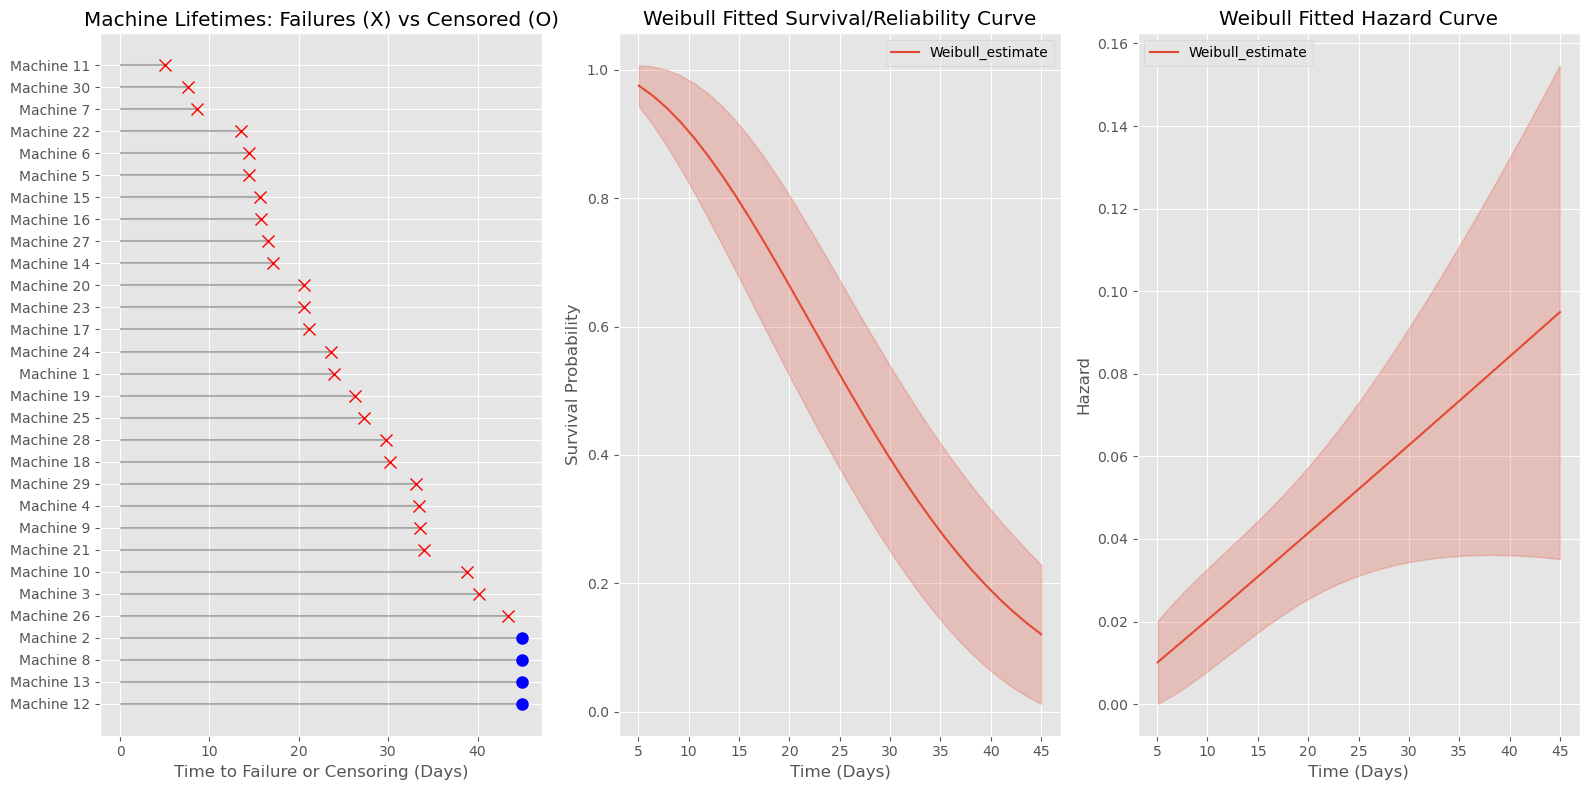

In [3]:
np.random.seed(42)

n_machines = 30
max_time = 45

true_failures = np.random.weibull(a=2, size=n_machines) * 35
event_times = np.clip(true_failures, 0, max_time)
observed = np.where(event_times < max_time, True,False)

df = pd.DataFrame({
    "machine_id": [f"Machine {i+1}" for i in range(n_machines)],
    "duration": event_times,
    "event": observed
}).sort_values(by="duration", ascending=True).reset_index(drop=True)

wf = WeibullFitter()
wf.fit(df['duration'], event_observed=df['event'])

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 8), gridspec_kw={"width_ratios": [1, 1,1]})

# Left plot: lollipop failure/censored plot
for i, row in df.iterrows():
    ax1.hlines(y=i, xmin=0, xmax=row['duration'], color='gray', alpha=0.6)
    marker = 'x' if row['event'] else 'o'
    color = 'red' if row['event'] else 'blue'
    ax1.plot(row['duration'], i, marker=marker, color=color, markersize=8)

ax1.set_yticks(range(n_machines))
ax1.set_yticklabels(df["machine_id"])
ax1.set_xlabel("Time to Failure or Censoring (Days)")
ax1.set_title("Machine Lifetimes: Failures (X) vs Censored (O)")
ax1.invert_yaxis()

# Right plot: fitted survival curve
wf.plot_survival_function(ax=ax2)
ax2.set_title("Weibull Fitted Survival/Reliability Curve")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Survival Probability")

wf.plot_hazard(ax=ax3)
ax3.set_title("Weibull Fitted Hazard Curve")
ax3.set_xlabel("Time (Days)")
ax3.set_ylabel("Hazard")

plt.tight_layout()
plt.show()


**Cox Proportional Hazards Models**  

When it comes to survival modeling, the Cox Proportional Hazards (CPH) model is the workhorse. It’s semi-parametric which is a fancy way of saying it doesn’t assume a specific baseline distribution like the Weibull, but instead focuses on how covariates (a.k.a. features) affect the hazard rate.

The model expresses the hazard for a subject at time *t* as:

$$
h(t) = h_0(t) \cdot \exp(\beta_1 x_{1} + \beta_2 x_{2} + \dots + \beta_p x_{p})
$$

Or more compactly:

$$
h(t) = h_0(t) \cdot \exp(\mathbf{x}^\top \boldsymbol{\beta})
$$

Where:  
- $h_0(t)$ is the **baseline hazard** (the risk when all covariates are zero)  
- $\boldsymbol{\beta}$ are the model coefficients  

This formulation lets us compare how different factors, like machine manufacturer or model scale the hazard function. A positive coefficient means increasing that feature boosts the hazard (bad news), while a negative one suggests it's protective.

One key assumption here is the **proportional hazards assumption**: the ratio of hazards between any two cohort members is **constant over time**. In other words, if Component A is twice as risky as Component B today, it stays twice as risky tomorrow and forever more.

For **inference**, this assumption can matter. And sometimes it can matter a lot! If you're making decisions or writing papers and this assumption doesn't hold, your hazard ratios might lie to you. But for **prediction**? Not a deal-breaker. If you're just trying to forecast failure probabilities and support operational decisions, you can often get away with it especially if you use **probability calibration techniques** down the line (e.g., Platt scaling, isotonic regression).

[<span style="color:blue">lifelines</span>](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html) has a great explanation in their documentation... just click the link to learn more.

**Note**: This notebook will not cover calibration as it is long enough already

---

**Cox Models with Time-Varying Covariates**  

Now let’s make things a bit more realistic. Out in the field, maintenance technicians, data teams, and reliability engineers often have deep knowledge of how telemetry signals,things like **increasing vibration**, or **voltage drift** can serve as early warning signs of impending failures. These patterns don’t stay fixed over time, and neither should our models

The basic form is the same, but the covariates are allowed to evolve over time:

$$
h(t) = h_0(t) \cdot \exp(\beta_1 x_{1}(t) + \beta_2 x_{2}(t) + \dots + \beta_p x_{p}(t))
$$

Same interpretability: coefficients still tell you the effect of a covariate on the hazard, but now **at a specific time**. So if component pressure is high at time *t*, and the coefficient for pressure is positive, then the model says “yeah, the risk is climbing *right now*.”

It still assumes proportional hazards, but now in the context of **instantaneous covariate values**. And again for **inference**, violations are a red flag. But for **predictive maintenance**, it’s usually fine. Our end goal is to rank machines by risk, not to get peer-reviewed.
"""


In [4]:
# Read In Data
df_tel  = pl.read_csv('/home/aveleyra/Documentos/mlops-exercise-walmart/data/PdM_telemetry.csv',try_parse_dates=True)
df_err  = pl.read_csv('/home/aveleyra/Documentos/mlops-exercise-walmart/data/PdM_errors.csv',try_parse_dates=True)
df_fail = pl.read_csv('/home/aveleyra/Documentos/mlops-exercise-walmart/data/PdM_failures.csv',try_parse_dates=True)
df_mach = pl.read_csv('/home/aveleyra/Documentos/mlops-exercise-walmart/data/PdM_machines.csv',try_parse_dates=True)
df_main = pl.read_csv('/home/aveleyra/Documentos/mlops-exercise-walmart/data/PdM_maint.csv',try_parse_dates=True)

## Exploratory Data Analysis 🔎

To demonstrate the practical utility of the Cox Proportional Hazards model for predictive maintenance, we'll be working with the **Microsoft Azure Predictive Maintenance dataset** — a synthetic yet well-structured dataset that simulates machine health over the course of a year across **100 unique machines**.

The available data includes:

1. **Telemetry data**: Hourly readings of Voltage, Rotation, Pressure, and Vibration  
2. **Errors**: Timestamped logs of error codes (types 1–5)  
3. **Maintenance records**: Logs of component replacements (components 1–4), regardless of failure  
4. **Failure records**: Logs of component replacements **due to failure**  
5. **Machine metadata**: Machine age and model type  

> 📌 **Note**: For simplicity, all data has been aggregated to the **daily level** for this analysis.

---

The goal of this **EDA** is to identify **early warning signals** of component failure that can serve as covariates in a **Cox Proportional Hazards (Cox PH)** model. We'll explore patterns and trends in telemetry data, error codes, and maintenance history to better understand the **failure dynamics** and prepare the data for survival modeling.


### Component Failures Across Machines

Since the predictive maintenance model Iare aiming to build is focused on component failures, let's look at the proportions of failures across the 4 components across all machines.   

Below Ican see Component 2 fails the most frequently while Component 3 fails the least.

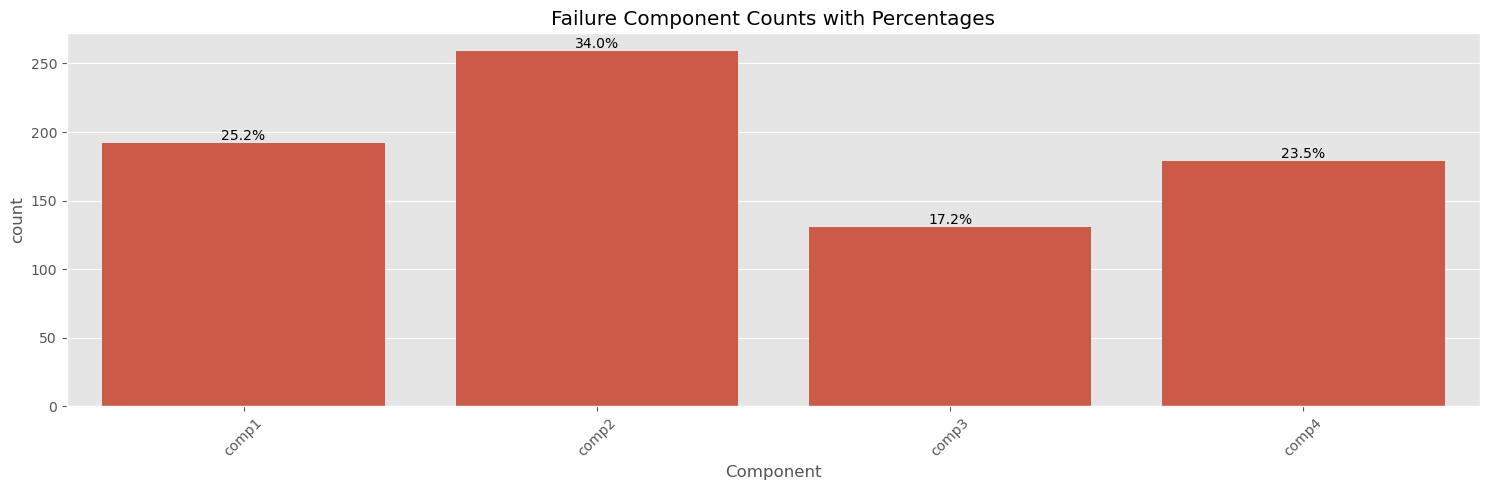

In [5]:
comp_fail_plot_df =(
         df_fail
        .select(pl.col("failure"))
        .to_series()
        .value_counts()
        .sort("failure")
).with_columns(percent = pl.col('count')/pl.col('count').sum()*100)

plt.figure(figsize=(15,5))
sns.barplot(data=comp_fail_plot_df.to_pandas(), x='failure', y='count')

for i, row in comp_fail_plot_df.to_pandas().iterrows():
    plt.text(i, row['count'], f"{row['percent']:.1f}%", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.title("Failure Component Counts with Percentages")

plt.xlabel("Component")
plt.tight_layout()

### Failures Across All Machines

If Ilook at the total number of failures across all machines Isee that machine **99** has the most failures with 18.

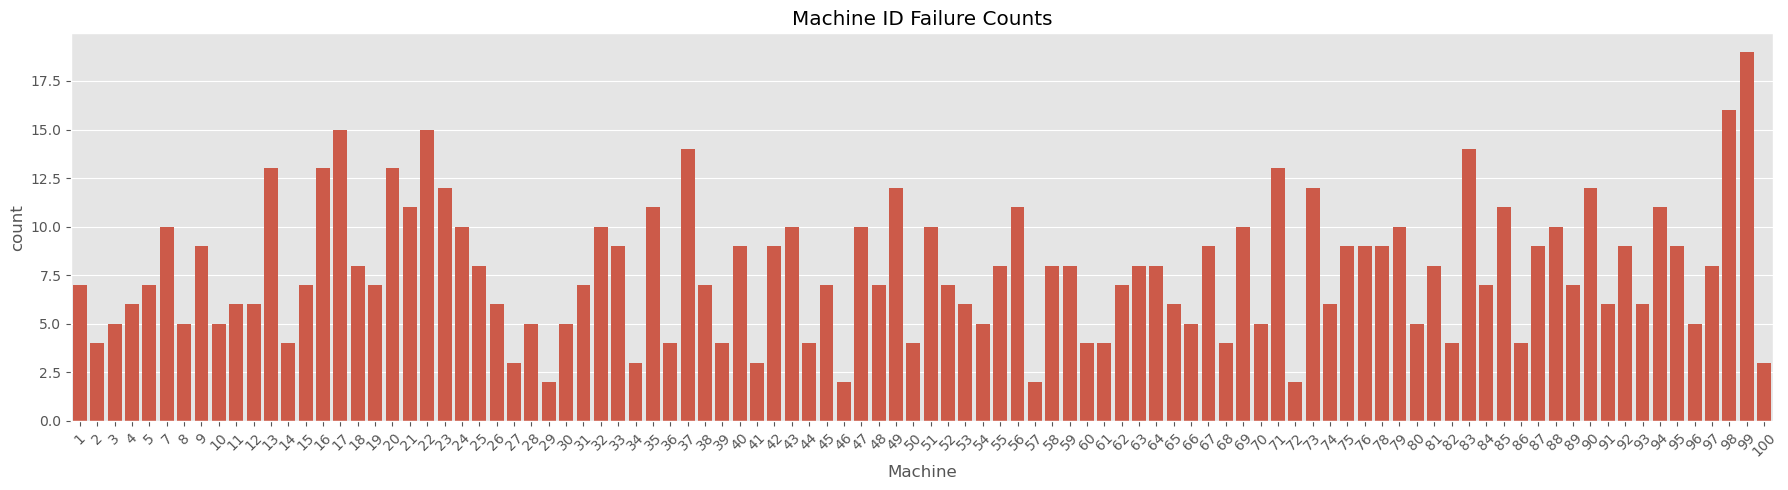

In [6]:
mach_fail_plot_df =(
         df_fail
        .select(pl.col("machineID"))
        .to_series()
        .value_counts()
        .sort("machineID")
).with_columns(percent = pl.col('count')/pl.col('count').sum()*100)

plt.figure(figsize=(18,5))
sns.barplot(data=mach_fail_plot_df.to_pandas(), x='machineID', y='count')
plt.title("Machine ID Failure Counts")
plt.xticks(rotation=45)
plt.xlabel("Machine")
plt.tight_layout()


### Pure Time Between Failures

Since our model will take into account the time to event, it is worthwhile to take a look at the distribution of time between failures across components.

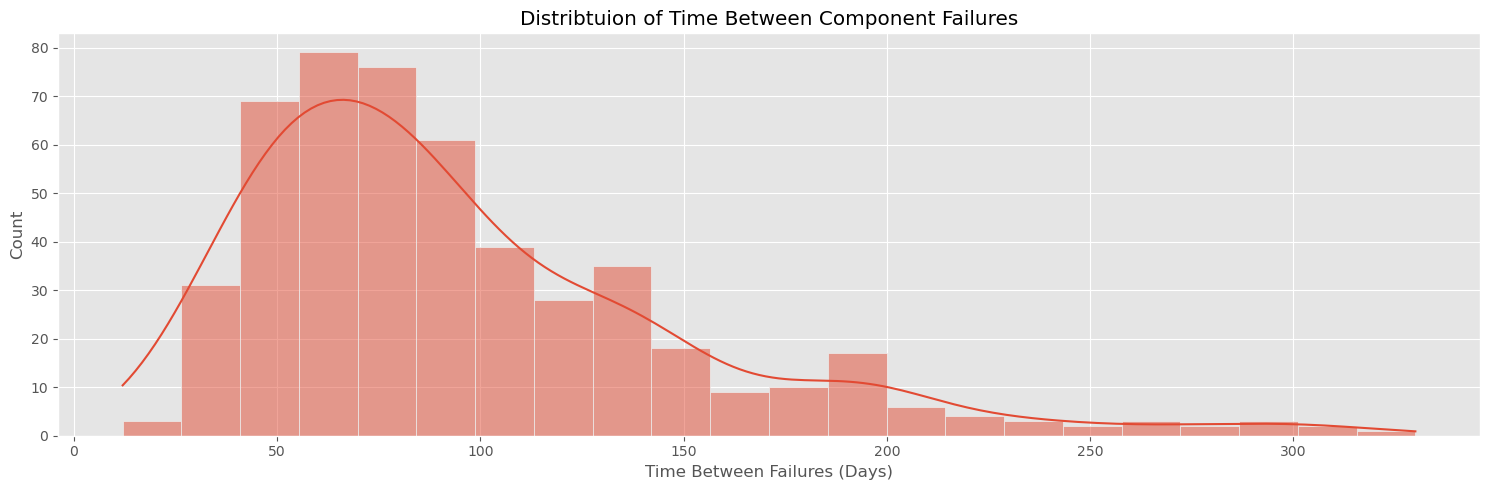

In [7]:
window_cols = ['machineID', 'failure']
sort_cols = window_cols +["datetime"]
time_to_fail_df = df_fail.with_columns(
    pl.col("datetime")
    .sort_by("datetime")
    .shift(-1)
    .over(window_cols)
    .alias("next_failure_time")
).with_columns((pl.col("next_failure_time")-pl.col("datetime")).dt.total_days().alias("time_between_failures")).drop_nulls()

plt.figure(figsize=(15,5))
sns.histplot(time_to_fail_df.to_pandas(),x="time_between_failures",kde=True)
plt.title("Distribtuion of Time Between Component Failures")
plt.xlabel("Time Between Failures (Days)")
plt.tight_layout()

### Time Between Component Failures
Here Ibreakout the distribution of time between component failures across all the 4 components on each machine.

Ican also see that the failure records occur in multiples of 15 days. (product of a contrived likely simulated dataset).

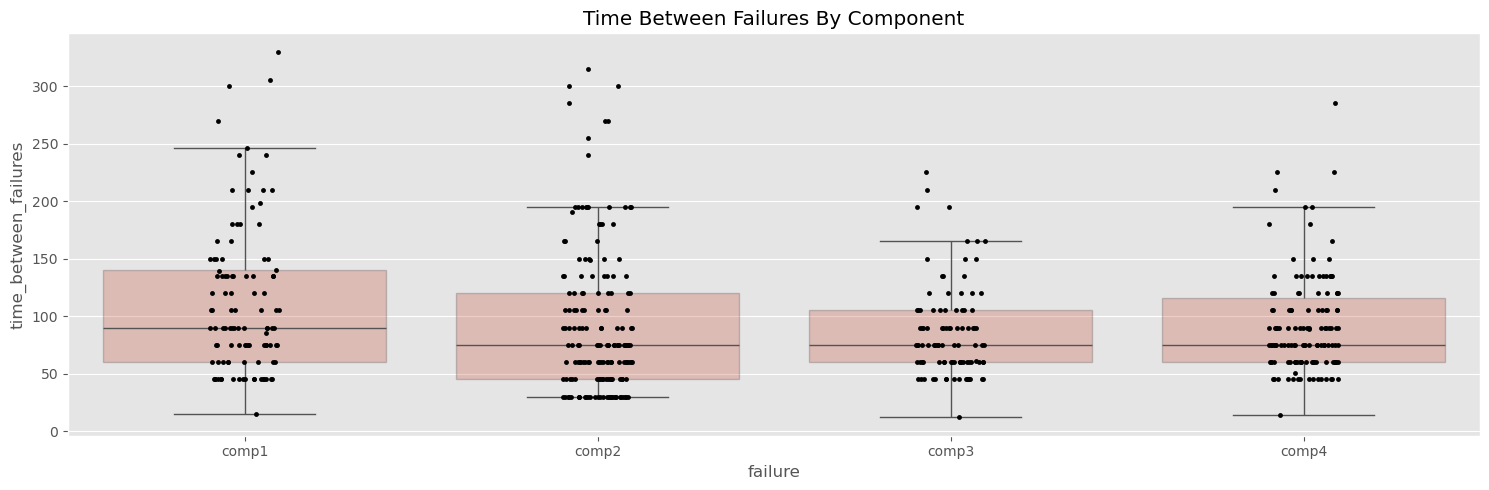

In [8]:
box_and_strip(df=time_to_fail_df.sort("failure").to_pandas(),x="failure",y="time_between_failures", title = "Time Between Failures By Component")

In [9]:
window_cols = ['machineID','comp']
sort_cols = ['datetime'] + window_cols
main_fail_flag_df = df_main.join(df_fail.with_columns(pl.lit(1).alias("fail_flag")),left_on=df_main.columns,right_on=df_fail.columns, how = 'left')
max_datetime = df_tel.select(pl.col("datetime").max()).to_series()[0]
time_between_fail_flag_df = create_time_between_fail_group_df(main_fail_flag_df,window_cols,max_datetime).join(df_mach,on="machineID",how="inner")

### Comparing time between regularly scheduled maintenance and maintenance to failure

This comparison shows that regular maintenance seems to require replacing the component every 15 days. For the instance marked 0 (in red) Ican see that most of the time components are replaced 15 days and that component failures occur when this regular maintenace was missed.

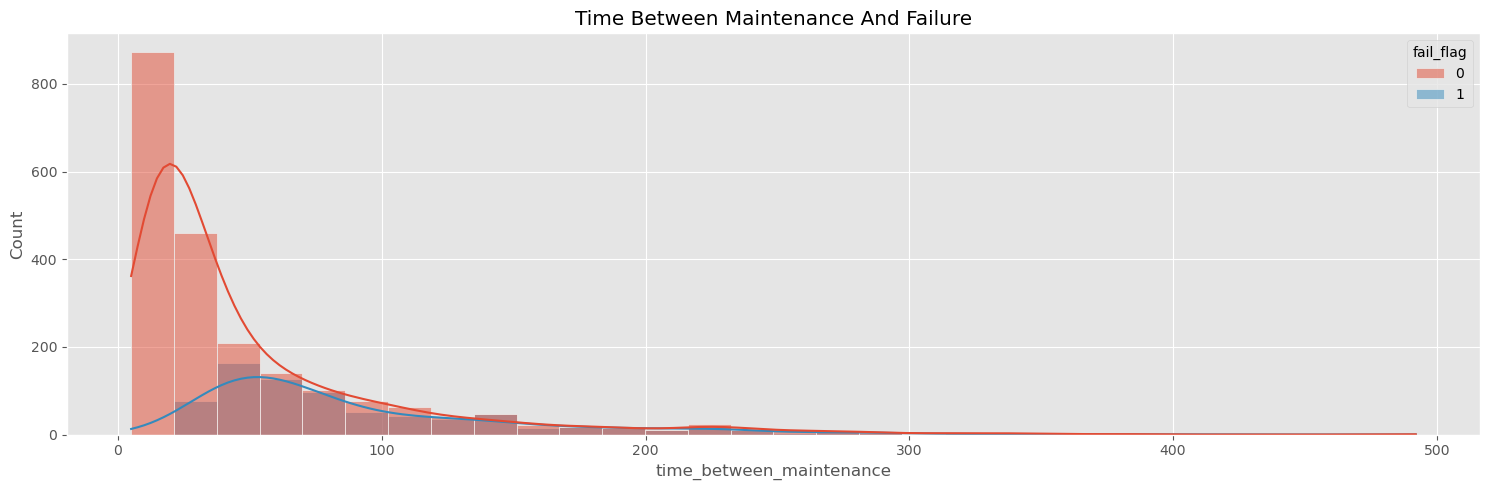

In [10]:
plt.figure(figsize=(15,5))
sns.histplot(time_between_fail_flag_df.to_pandas(),x='time_between_maintenance',kde=True,bins=30,hue="fail_flag")
plt.title("Time Between Maintenance And Failure")
plt.tight_layout()

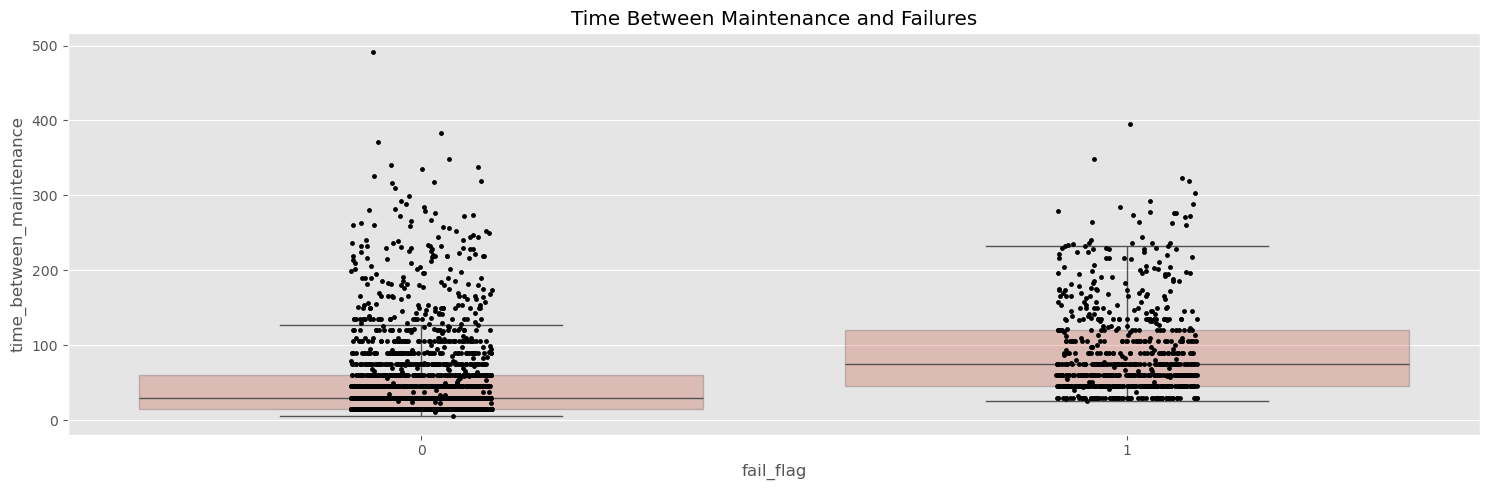

In [11]:
box_and_strip(time_between_fail_flag_df.to_pandas(),x="fail_flag",y="time_between_maintenance",title="Time Between Maintenance and Failures",)

### Create Daily Plot Telemetry df

In [12]:
daily_agg_df = (
    df_tel
    .with_columns(pl.col("datetime").dt.date().alias("date"))
    .group_by(["machineID", "date"])
    .agg([
        pl.col("volt").mean().alias("mean_daily_voltage"),
        pl.col("rotate").mean().alias("mean_daily_rotation"),
        pl.col("pressure").mean().alias("mean_daily_pressure"),
        pl.col("vibration").mean().alias("mean_daily_vibration"),
    ]))

daily_fail_pivot_df = event_pivoter(df_fail,"failure")
daily_error_pivot_df = event_pivoter(df_err,"errorID")
daily_maint_pivot_df = event_pivoter(df_main,"comp")

daily_plot_df=(daily_agg_df
              .join(daily_error_pivot_df,on=["machineID","date"],how="left")
              .join(daily_maint_pivot_df,on=["machineID","date"],how="left")
              .join(daily_fail_pivot_df, on=["machineID","date"],how="left",suffix="_failure")
              .fill_null(0)
              .sort(["machineID","date"]))

## Telemetry Data 📈

After looking at much of the telemetry data, I found that in this contrived likely A.I. generated dataset there were particular patterns of failure that can be seen across each component. The following plots will detail each one and they will ultimately inform the modeling strategy.

In the plots below the solid vertical lines are on the day of a component failure, the dashed lines are on the day of a scheduled maintenance and the dotted lines represent the day an error was tripped.

### Component 1 Failure Signatures

A common pattern shown for a component 1 failure is that there is a spike in the **Voltage** and **Error 1** is tripped the previous day. This persists throughout the dataset and can be seen in the example below.

**Machine ID 79**

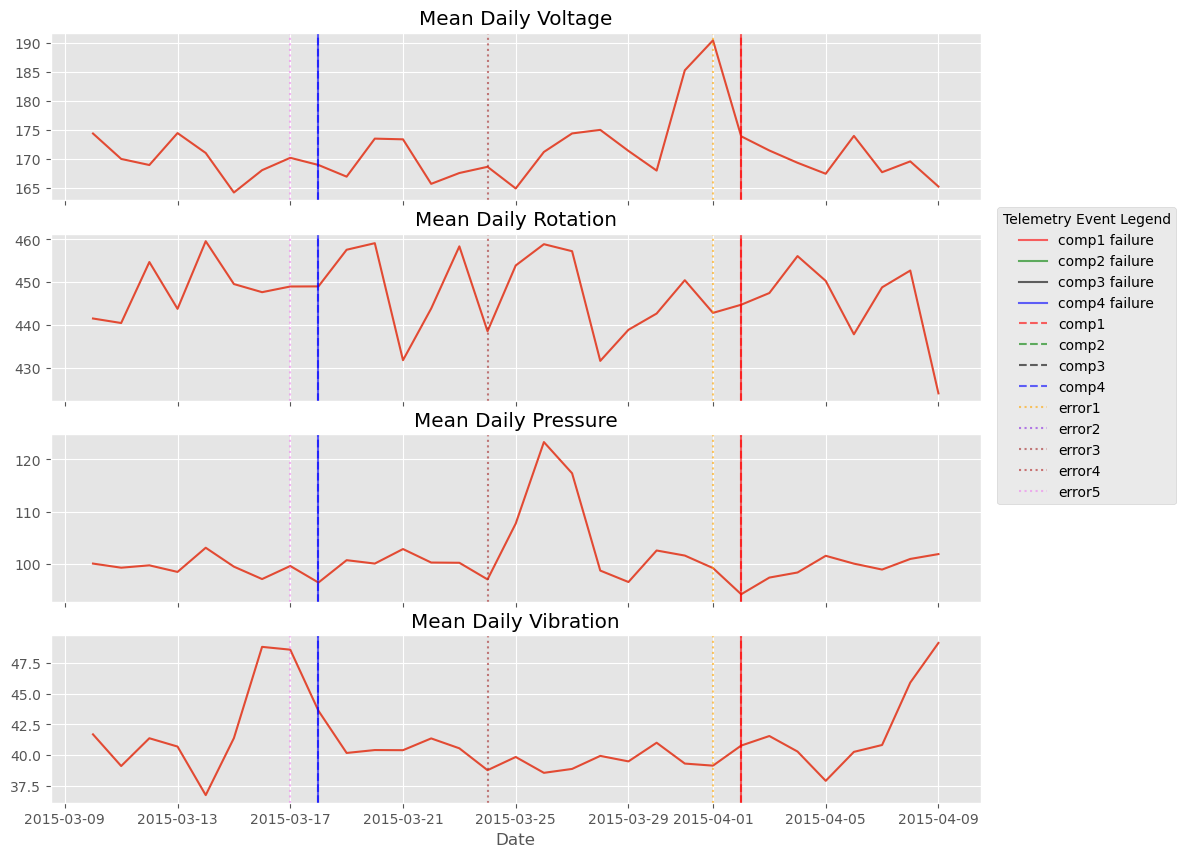

In [13]:
sensor_cols=[col for col in daily_plot_df.columns if col.startswith("mean")]
start=datetime(2015,3,10)
end = start + timedelta(days=30)
machine_id = 79
plot_df= (
    daily_plot_df
    .filter(pl.col("machineID")==machine_id)
    .filter(pl.col("date").is_between(start,end))
    .sort("date",descending=False)
)

plot_timeseries_stacked(plot_df.to_pandas(),sensor_cols)

### Component 2 Failure Signatures

A common pattern shown for a component 2 failure is that there is a dip in the **Rotation** and **Error 2 and Error 3** are tripped the previous day. This persists throughout the dataset and can be seen in the example below.

**Machine ID 23**

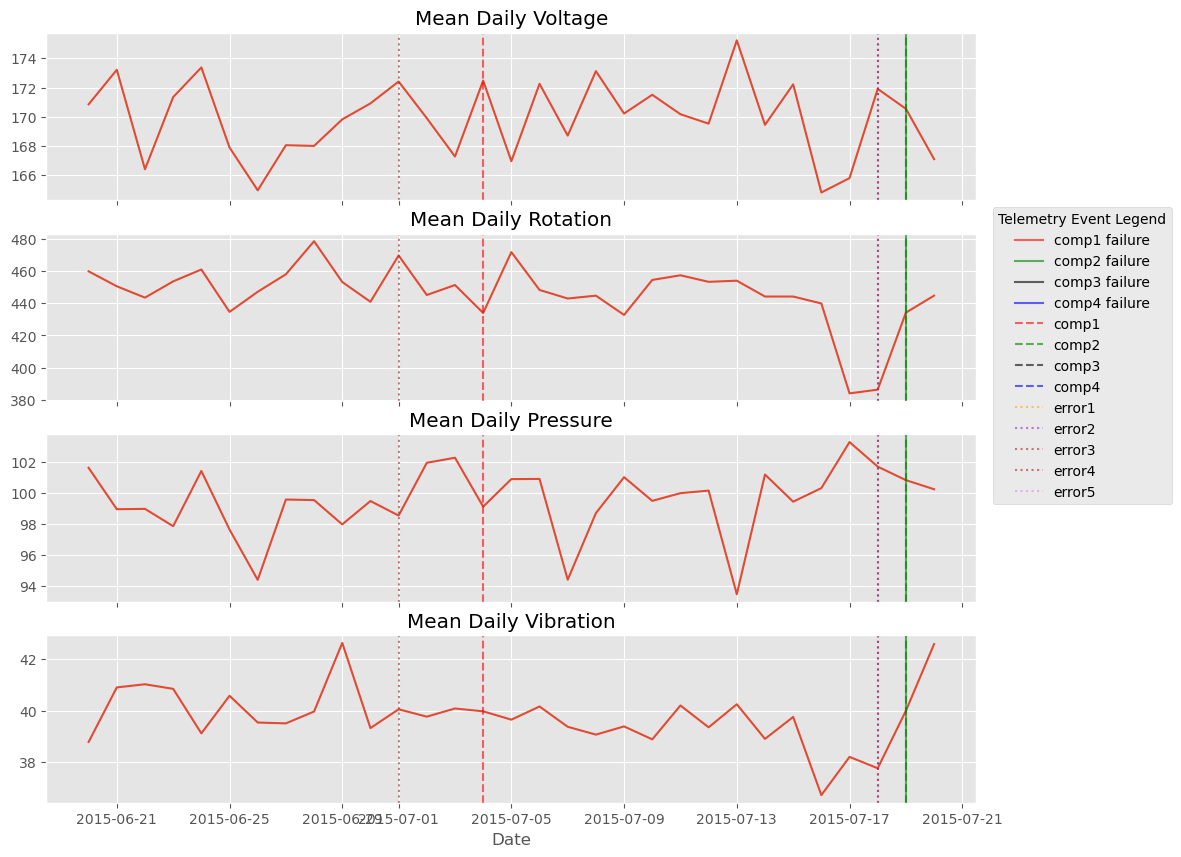

In [14]:
sensor_cols=[col for col in daily_plot_df.columns if col.startswith("mean")]
start=datetime(2015,6,20)
end = start + timedelta(days=30)
machine_id = 23
plot_df= (
    daily_plot_df
    .filter(pl.col("machineID")==machine_id)
    .filter(pl.col("date").is_between(start,end))
    .sort("date",descending=False)
)

plot_timeseries_stacked(plot_df.to_pandas(),sensor_cols)

### Component 3 Failure Signatures

A common pattern shown for a component 3 failure is that there is a spike in the **Pressure** and **Error 4** is tripped the previous day. This persists throughout the dataset and can be seen in the example below.

**Machine ID 42** 😉


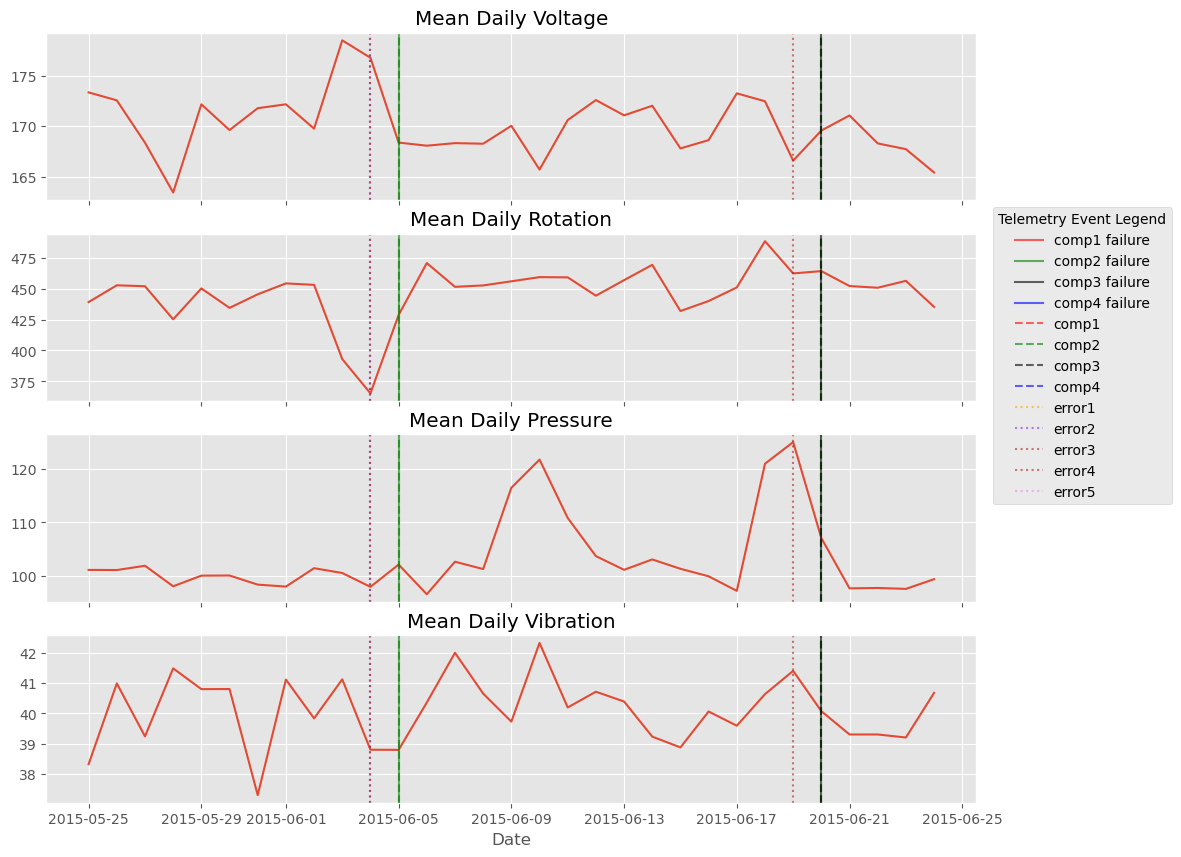

In [15]:
sensor_cols=[col for col in daily_plot_df.columns if col.startswith("mean")]
start=datetime(2015,5,25)
end = start + timedelta(days=30)
machine_id = 42
plot_df= (
    daily_plot_df
    .filter(pl.col("machineID")==machine_id)
    .filter(pl.col("date").is_between(start,end))
    .sort("date",descending=False)
)

plot_timeseries_stacked(plot_df.to_pandas(),sensor_cols)

### Component 4 Failure Signatures

A common pattern shown for a **component 4 failure** is that there is a spike in the **Vibration** and **Error 5** is tripped the previous day. This persists throughout the dataset and can be seen in the example below.

**Machine ID 51**

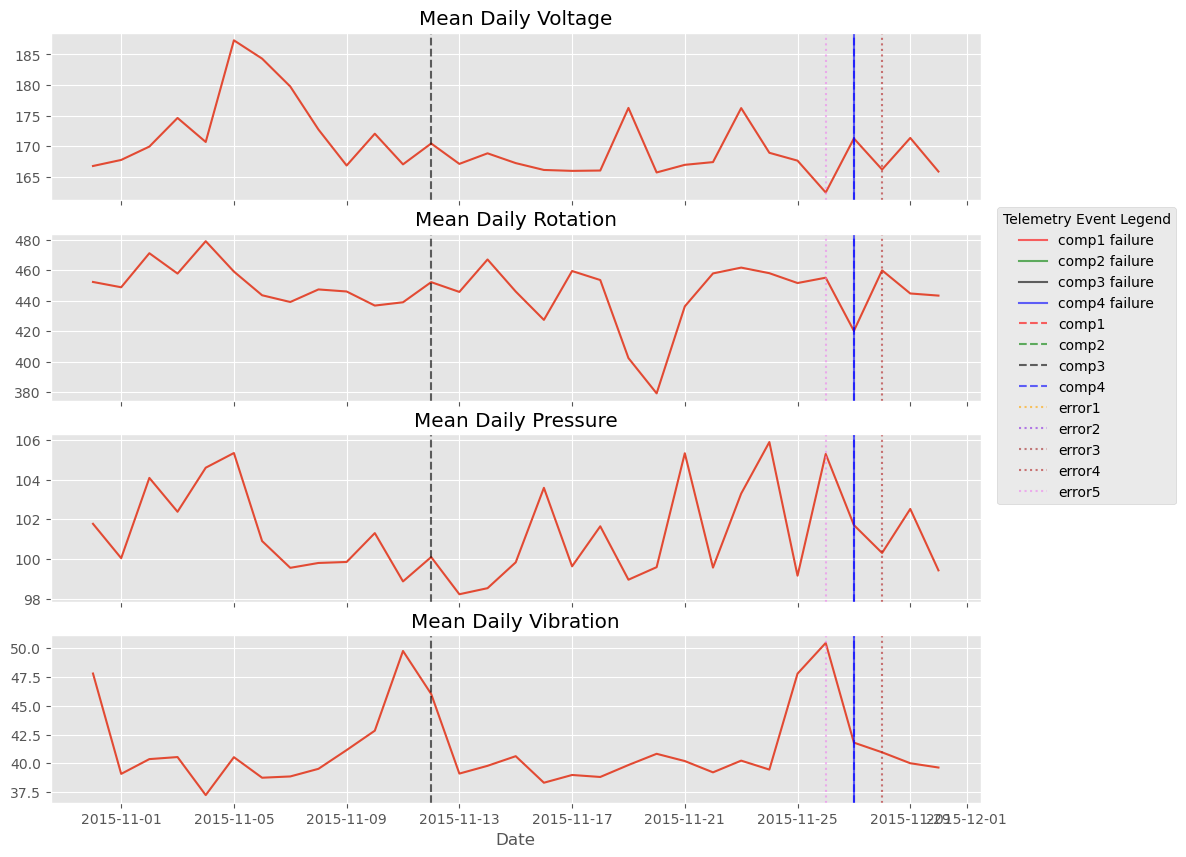

In [16]:
sensor_cols=[col for col in daily_plot_df.columns if col.startswith("mean")]
start=datetime(2015,10,31)
end = start + timedelta(days=30)
machine_id = 51
plot_df= (
    daily_plot_df
    .filter(pl.col("machineID")==machine_id)
    .filter(pl.col("date").is_between(start,end))
    .sort("date",descending=False)
)

plot_timeseries_stacked(plot_df.to_pandas(),sensor_cols)

## Fitting Weibull Survival and Hazard Model 🔵

The curves below show the **Survival** and **Hazard** functions for each of the 4 model types. This does not take into account components, but rather models the time to failure between any components on a given machine.

It is evident that both **Model 1** and **Model 2** machines have less reliability (less time between failures) when compared to **Model 3** and **Model 4**.

In [17]:
component_weibull_dict = create_survival_model_dict(fail_flag_df=time_between_fail_flag_df,model=WeibullFitter,group_level_col="model",duration_col="time_between_maintenance",observe_col="fail_flag")

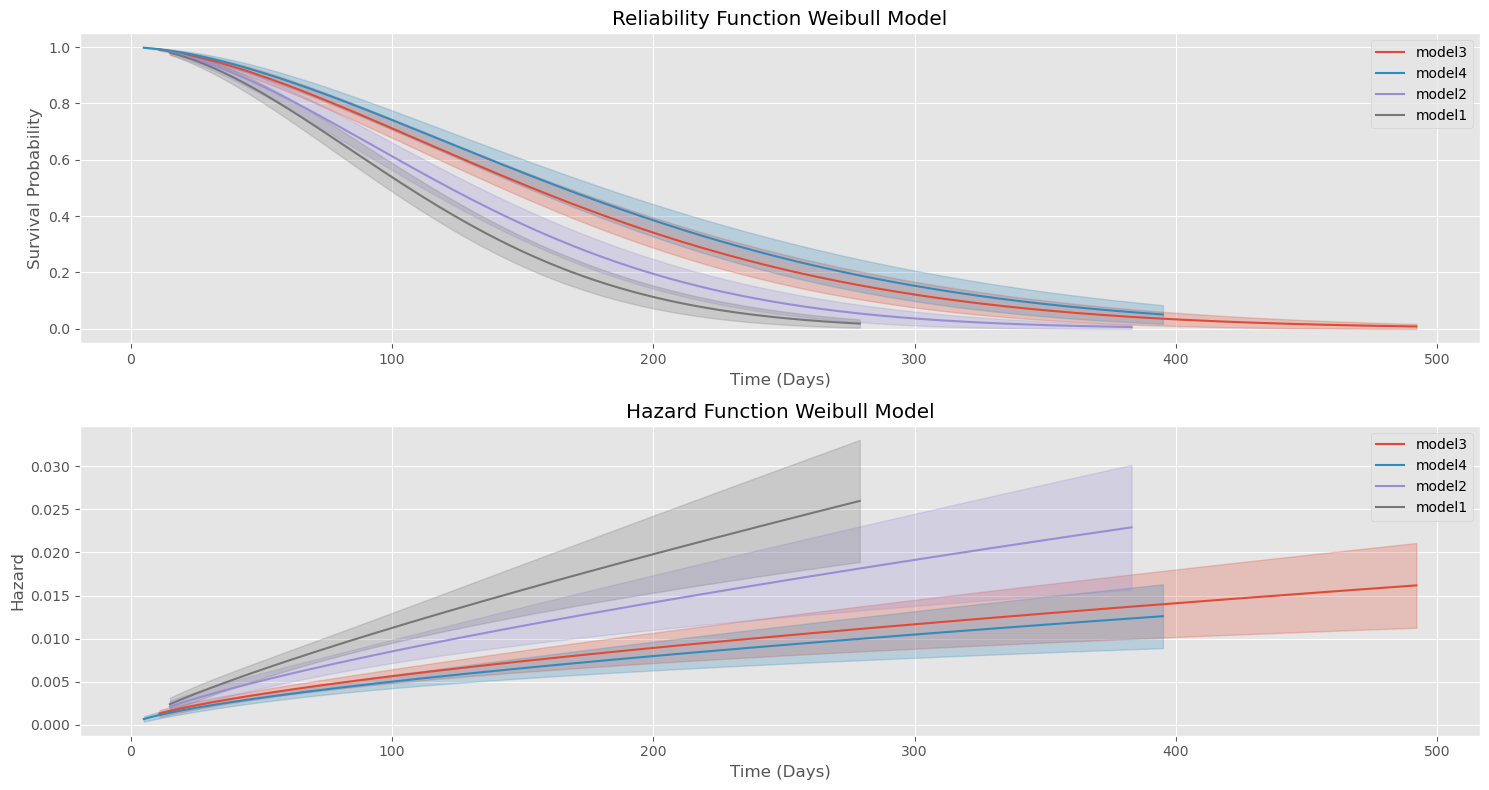

In [18]:
survival_hazard_group_plotter(component_weibull_dict,model_name="Weibull Model")

## Features To Be Used For COX PH Model 🤖

From the analysis of the telemetry data, it was discovered that each component prior to failure tends to show a large **Spike** or **Dip** in a specific telemetry value around 2 days before the component is replaced due to failure.  

To capture these deviations more robustly, I will compute **21-day rolling means and rolling standard deviations** for each telemetry variable and then calculate a **z-score** for the current day's reading relative to the past 21 days. If the **z-score** on a given day is over a certain threshold... say 2.5, that day will be flagged as being an anomalous telemetry measurement and used as a time varying predictor in the model.

Using these anomaly flags, I will train **4 COX PH models** (one for each component) with:
- **Fixed variables**: Machine model type and machine age  
- **Time-varying predictor**: 21-day rolling z-score anomaly flag which will be a binary 0 or 1

Below are the components and their associated telemetry signals:

- **Component 1** → Spike in Voltage  
- **Component 2** → Dip in Rotation  
- **Component 3** → Spike in Pressure  
- **Component 4** → Spike in Vibration


**The z-score calculation is performed in the cell below**

In [20]:
mean_telemetry_cols = [
    "mean_daily_voltage",
    "mean_daily_rotation",
    "mean_daily_pressure",
    "mean_daily_vibration",
]

window_size = 21  # filas (≈ días si hay 1 registro/día)
z_anomaly_threshold = 2.3

daily_telemetry_z_df = (
    daily_plot_df
    .sort(["machineID", "date"])
    .with_columns(
        [
            # medias móviles por máquina
            pl.col(c).rolling_mean(window_size=window_size).over("machineID")
            .alias(f"rolling_avg_{window_size}d_{c}")
            for c in mean_telemetry_cols
        ]
        +
        [
            # std móviles por máquina
            pl.col(c).rolling_std(window_size=window_size).over("machineID")
            .alias(f"rolling_std_{window_size}d_{c}")
            for c in mean_telemetry_cols
        ]
    )
    .with_columns(
        [
            pl.when(pl.col(f"rolling_std_{window_size}d_{c}") > 0)
            .then(
                (pl.col(c) - pl.col(f"rolling_avg_{window_size}d_{c}"))
                / pl.col(f"rolling_std_{window_size}d_{c}")
            )
            .otherwise(None)
            .alias(f"zscore_{window_size}d_{c}")
            for c in mean_telemetry_cols
        ]
    )
    .with_columns(
        [
            (pl.col(f"zscore_{window_size}d_{c}").abs() >= z_anomaly_threshold)
            .cast(pl.Int8)
            .alias(f"anomaly_flag_{window_size}d_{c}")
            for c in mean_telemetry_cols
        ]
    )
)


## Build Time-Varying Covariates Dataset 🏢

The [<span style="color:blue">lifelines</span>](https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html) documentation provides a great overview of the required data format for fitting a `CoxTimeVaryingFitter` model. I highly recommend reviewing it if you're unfamiliar with the structure.

At a high level, the time-varying format expects:

- An **ID column** to track each unique subject (in our case, machine-component instances)
- A **`start`** and **`stop`** column denoting the duration of each observation interval
- An **`event`** column indicating whether the event of interest (i.e., failure) occurred during that interval

For this predictive maintenance use case, we'll assume the model is used by a maintenance team performing **daily checks**, so we’ll generate **one record per day per machine-component instance**.

To do this, I construct a unique identifier for each component lifecycle, which I will call the `component_instance_id`. This is a composite key combining:
- `MachineID`
- `ComponentID`
- `Component Instance` (an incrementing counter each time a component is replaced)

In the code cell below, I demonstrate how to construct this time-varying dataset using **Polars**, ensuring alignment with available telemetry data.

---

Once the dataset is built, I filter it to include only dates where telemetry data is available. I then split the dataset into:
- **Training set**: First 6 months of the year  
- **Validation set**: Last 6 months of the year


In [25]:


# Fechas globales (opcional: start_date no se usa abajo, pero lo conservo por si lo necesitas)
start_date = df_main.select(
    pl.col("datetime").dt.date().min().alias("start_date")
).item()

end_date = df_tel.select(
    pl.col("datetime").dt.date().max().alias("end_date")
).item()

# --- main_prejoin_df ---
main_prejoin_df = (
    df_main
    .with_columns(pl.col("datetime").dt.date().alias("date"))  # crear columna date (tipo Date)
    .drop("datetime")
    .sort(["machineID", "comp", "date"])
    .with_columns([
        # índice de instancia por grupo: 0..n-1 usando cum_count sobre una columna real
        (pl.col("date").cum_count().over(["machineID", "comp"]) - 1)
            .cast(pl.Utf8)
            .alias("component_instance"),

        # siguiente fecha dentro del grupo para marcar fin del rango
        pl.col("date").shift(-1).over(["machineID", "comp"]).alias("end_date"),
    ])
    .with_columns([
        # ID compuesto
        (
            pl.col("machineID").cast(pl.Utf8)
            + pl.lit("-")
            + pl.col("comp")
            + pl.lit("-")
            + pl.col("component_instance")
        ).alias("component_instance_id"),

        # rellenar end_date nulas con el end_date global
        pl.col("end_date")
          .fill_null(pl.lit(end_date).cast(pl.Date))
          .alias("end_date"),
    ])
    .with_columns([
        # generar rango diario: incluye el final y excluye el inicio (closed="right")
        pl.date_ranges(
            start=pl.col("date"),
            end=pl.col("end_date"),
            interval="1d",
            closed="right",
        ).alias("date_range"),
    ])
    .explode("date_range")
    .drop(["date", "end_date"])
    .rename({"date_range": "date"})
)

# --- fail_prejoin_df ---
fail_prejoin_df = (
    df_fail
    .with_columns([
        pl.lit(True).alias("component_failure"),
        pl.col("datetime").dt.date().alias("date"),
        pl.col("failure").alias("comp"),
    ])
    .drop(["datetime", "failure"])
)


In [27]:
daily_component_fail_df = (
    main_prejoin_df
    .join(fail_prejoin_df, on=["machineID", "comp", "date"], how="left")
    .with_columns([
        pl.col("component_failure").fill_null(False).alias("component_failure"),
        (
            pl.col("date")
            - pl.col("date").min().over("component_instance_id")
        ).dt.total_days().alias("start")
    ])
    .with_columns(
        (pl.col("start") + 1).alias("end")
    )
)


### Filter Pre Telemetry Data

The below code filters out ```component_instance_ids``` that were active prior to their being available telemetry data.


In [28]:
# Get date with earliest telemetry data
earliest_telem_date=df_tel.select(pl.col("datetime").dt.date().min().alias("end_date")).item()
# Create pre telemetry component instance ids
pre_telem_component_instance_list=daily_component_fail_df.filter(pl.col("date") <earliest_telem_date).select("component_instance_id").to_series().unique()
# Filter out component instance ids with no telemetry data
daily_component_fail_df_filtered=daily_component_fail_df.filter(~pl.col("component_instance_id").is_in(pre_telem_component_instance_list))

### Create Train and Validation DataFrames

The `create_train_test_df` method performs the following:

1. Splits the DataFrame using the `split_date`.
2. Shifts telemetry variables **2 days ahead** in the **training data only**.
3. Leaves telemetry data in the **validation set unshifted**.
4. Returns `train_df` and `val_df`.

This setup allows the model output (when converted to a probability) to be interpreted as:

**The probability of a component failing 2 days from now.**


In [29]:
telemetry_cols=[ 'anomaly_flag_21d_mean_daily_voltage',
                 'anomaly_flag_21d_mean_daily_rotation',
                 'anomaly_flag_21d_mean_daily_pressure',
                 'anomaly_flag_21d_mean_daily_vibration']
model_df = (daily_component_fail_df_filtered
          .join(daily_telemetry_z_df,on=["date","machineID"])
          .join(df_mach, on="machineID")
           )
split_date = datetime(2015,6,30)
train_df, val_df = create_train_test_df(model_df, split_date,telemetry_cols,strategy="backward")

In [30]:
train_df.head()

machineID,comp,component_instance,component_instance_id,date,component_failure,start,…,zscore_21d_mean_daily_vibration,anomaly_flag_21d_mean_daily_voltage,anomaly_flag_21d_mean_daily_rotation,anomaly_flag_21d_mean_daily_pressure,anomaly_flag_21d_mean_daily_vibration,model,age
i64,str,str,str,date,bool,i64,…,f64,i8,i8,i8,i8,str,i64
1,"""comp1""","""1""","""1-comp1-1""",2015-01-06,false,0,…,null,0,0,0,0,"""model3""",18
1,"""comp1""","""1""","""1-comp1-1""",2015-01-07,false,1,…,null,0,0,0,0,"""model3""",18
1,"""comp1""","""1""","""1-comp1-1""",2015-01-08,false,2,…,null,0,0,0,0,"""model3""",18
1,"""comp1""","""1""","""1-comp1-1""",2015-01-09,false,3,…,null,0,0,0,0,"""model3""",18
1,"""comp1""","""1""","""1-comp1-1""",2015-01-10,false,4,…,null,0,0,0,0,"""model3""",18


### Train and Store Models

The code below will iterate through each component and use its designated telemetry predictor variable to fit the **Cox PH** Model and store the trained model in the ```model_store``` dictionary.

In [31]:
# Create Component to Telemetry Variable Mapping
comp_telemetry_map = {"comp1":"anomaly_flag_21d_mean_daily_voltage",
                     "comp2":"anomaly_flag_21d_mean_daily_rotation",
                     "comp3":"anomaly_flag_21d_mean_daily_pressure",
                     "comp4":"anomaly_flag_21d_mean_daily_vibration"
                     }

model_store = dict()

# Iterate through all components
for comp in ["comp1","comp2", "comp3", "comp4"]:
    print(comp)
    formula = f"age + C(model) + {comp_telemetry_map[comp]}"
    print(formula)
    ctv = CoxTimeVaryingFitter(penalizer=0.01)

    ctv.fit(
        df=train_df.to_pandas(),
        event_col=f"{comp}_failure",
        start_col="start",
        stop_col="end",
        id_col="component_instance_id",
        formula=formula
    )

    model_store[comp] = ctv




comp1
age + C(model) + anomaly_flag_21d_mean_daily_voltage
comp2
age + C(model) + anomaly_flag_21d_mean_daily_rotation
comp3
age + C(model) + anomaly_flag_21d_mean_daily_pressure
comp4
age + C(model) + anomaly_flag_21d_mean_daily_vibration


### Model Interpretation

Below is the output of the `print_summary` method from **lifelines** for the **Component 3** model.

The key column to focus on is `exp(coef)`, which represents the **hazard ratio**, the multiplicative effect on the baseline hazard when a covariate increases by one unit (or is present, for binary variables).

---

#### What does `exp(coef)` mean for our features?

- **Machine model type (categorical)**:  
    - Machines of **Model 2** have a hazard **1.52× higher** than the baseline **Model 1** — a **52% increase in risk** of Component 3 failure.  
    - Machines of **Model 3** have a hazard **0.68×** the baseline — a **32% decrease in risk**.  
    - Machines of **Model 4** have a hazard **0.72×** the baseline — a **28% decrease in risk**.  

- **Anomaly flag for rolling z-score of mean daily pressure (`anomaly_flag_21d_mean_daily_pressure`)**:  
    - `exp(coef) = 15.35`, which means when the anomaly flag = **1** (indicating the absolute z-score of mean daily pressure was greater than 2.3 based on a 21-day rolling window), the hazard is **15.3× higher** compared to when the flag = 0.  
    - This is a very strong effect and confirms that extreme deviations in pressure are highly predictive of imminent failure.

---


In [34]:
model_store["comp3"].print_summary()

AttributeError: The '.style' accessor requires jinja2

<lifelines.CoxTimeVaryingFitter: fitted with 52523 periods, 1371 subjects, 171 events>
         event col = 'comp3_failure'
         penalizer = 0.01
number of subjects = 1371
 number of periods = 52523
  number of events = 171
partial log-likelihood = -855.83
  time fit was run = 2025-09-18 19:27:45 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
age                                   0.00      1.00      0.01           -0.01            0.02                0.99                1.02
C(model)[T.model2]                    0.41      1.51      0.10            0.22            0.60                1.25                1.83
C(model)[T.model3]                   -0.38      0.68      0.08           -0.54           -0.22                0.58                0.80
C(model)[T.model4]                   -0.33      0.72      0.08           -0.50           -0.17                0.61                0.85
anomaly_flag_21d_mean_daily_pressure  2.73     15.26      0.13            2.47            2.98               11.84               19.66

                                      cmp to     z      p  -log2(p)
covariate                                                          
age                                     0.00  0.45   0.65      0.62
C(model)[T.model2]                      0.00  4.28 <0.005     15.73
C(model)[T.model3]                      0.00 -4.67 <0.005     18.35
C(model)[T.model4]                      0.00 -3.94 <0.005     13.61
anomaly_flag_21d_mean_daily_pressure    0.00 21.08 <0.005    325.31
---
Partial AIC = 1721.66
log-likelihood ratio test = 452.95 on 5 df
-log2(p) of ll-ratio test = 315.40

### Calculating Failure Probability from Baseline Cumulative Hazard

The **Cox model** assumes the hazard function for an individual with covariates $X(t)$ is:

$$
h(t|X(t)) = h_0(t) \cdot \exp(\beta^\top X(t))
$$

where:
- $h_0(t)$ is the **baseline hazard**,
- $\exp(\beta^\top X(t))$ is the **partial hazard** (risk multiplier).

The **cumulative hazard** is defined as the integral of the hazard over time:

$$
H(t|X(t)) = \int_0^t h(u|X(u)) \, du = \int_0^t h_0(u) \cdot \exp(\beta^\top X(u)) \, du
$$

The **baseline cumulative hazard**, estimated by the `baseline_cumulative_hazard_` attribute from `lifelines`.

---

#### From Cumulative Hazard to Survival and Failure Probability:

The survival function is:

$$
S(t|X(t)) = \exp\big(-H(t|X(t))\big) = \exp\big(-H_0(t) \cdot \exp(\beta^\top X(t))\big)
$$

The probability of failure by time **t** is:

$$
P(\text{failure by } t|X(t)) = 1 - S(t|X(t))
$$

---

#### Implementation Details:
- `data_baseline_ch` = $H_0(t)$ (baseline cumulative hazard at time $t$)
- `partial_hazard` = $\exp(\beta^\top X(t))$ (from `predict_partial_hazard`)
- Then:

$$
P(\text{failure by } t|X(t)) = 1 - \exp\big(- H_0(t) \cdot \text{partial\_hazard}\big)
$$

---

**Important Note:**  
**I shifted telemetry data forward by 2 days** for the **training set only**.  
Therefore, these predicted probabilities represent:

$$
\text{Probability of failure occurring within 2 days from model prediction.}
$$


**The cell below will calculate the failure probability within 2 days from inference time**

In [35]:
val_pd = val_df.to_pandas().copy()
df_list = []
for comp, ctv in model_store.items():
    col_name = f"{comp}_failure_proba"
    val_pd[col_name] = predict_failure_proba(val_pd, ctv)
    val_pd[f"{comp}_partial_hazard"] = ctv.predict_partial_hazard(val_pd)
validation_analysis_df = pl.from_pandas(val_pd)



### Component 4 Vibration Model Example

The plot below illustrates the **Cox Proportional Hazards (PH) model** applied to **Component 4**, where the time-varying predictor is the **vibration anomaly flag**.

The bottom panel shows the model’s estimated **daily failure probability** for a single component instance over its operating life. Key observations:

- **Early-life anomaly (September):**  
  The anomaly flag briefly triggers a spike early in the component’s life. However, because the Cox PH model accounts for **time-dependent baseline risk**, this anomaly has a negligible impact on failure probability when the component is new.

- **Late-life anomaly (December):**  
  After several months of operation, the component accumulates higher baseline risk. When the anomaly flag activates again in December, the model predicts a **failure probability approaching 100% within the next 2 days** which aligns with the observed failure event.

This behavior demonstrates the strength of the proportional hazards approach:  
It combines **increasing baseline risk over time** with **real-time anomaly detection**, providing interpretable and dynamic failure risk estimates.


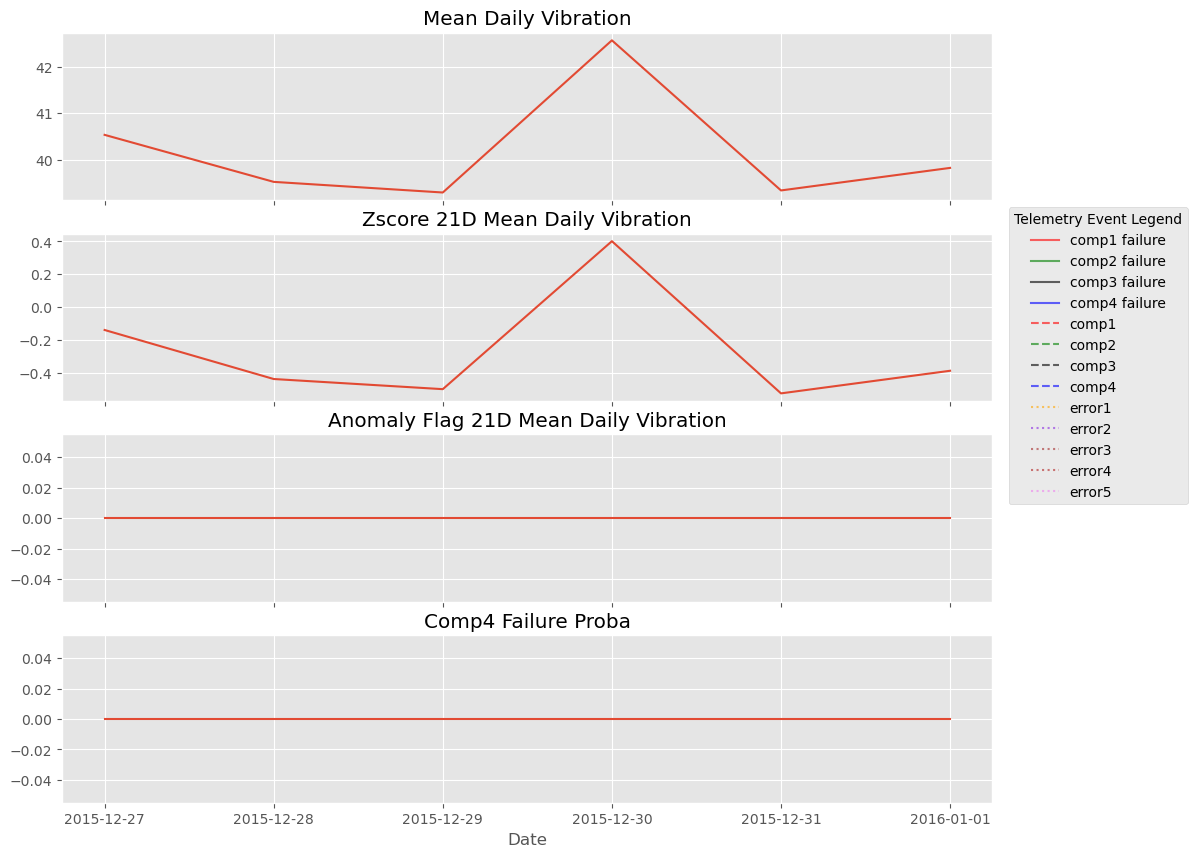

In [36]:
plot_columns=["mean_daily_vibration",
              "zscore_21d_mean_daily_vibration",
              "anomaly_flag_21d_mean_daily_vibration",
              "comp4_failure_proba"
             ]
plot_df= (
    validation_analysis_df
    .filter(pl.col("component_instance_id")=="85-comp4-4")
)

plot_timeseries_stacked(plot_df.to_pandas(),plot_columns)

### Component 3 Pressure Model Example

The plot below illustrates the **Cox Proportional Hazards (PH) model** applied to **Component 3**, where the time-varying predictor is the **pressure anomaly flag**.

The bottom panel shows the model’s estimated **daily failure probability** for a single component instance over its operating life. Key observations:

- **Mid-life anomaly (July):**  
  The anomaly flag triggers a spike midway through the component’s life. However, because the Cox PH model accounts for **time-dependent baseline risk**, the effect is modest compared to later anomalies.

- **Late-life anomaly (August):**  
  A second anomaly flag occurs in late August, after the component has accumulated substantial baseline risk and missed several scheduled 15-day maintenance intervals. At this point, the model predicts a sharp increase in failure probability, signaling a high likelihood of imminent failure.



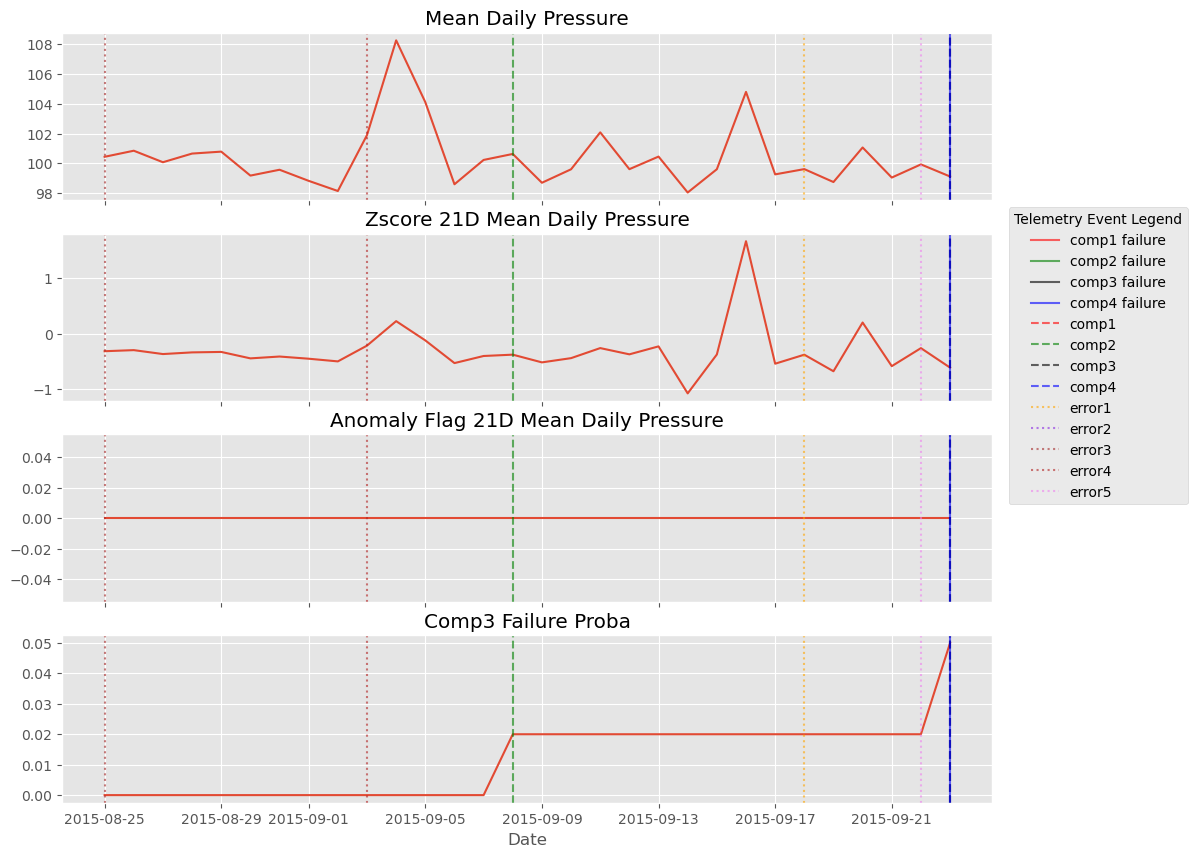

In [37]:
plot_columns=["mean_daily_pressure",
              "zscore_21d_mean_daily_pressure",
              "anomaly_flag_21d_mean_daily_pressure",
              "comp3_failure_proba"
             ]
plot_df= (
    validation_analysis_df
    .filter(pl.col("component_instance_id")=="13-comp3-5")
)

plot_timeseries_stacked(plot_df.to_pandas(),plot_columns)

### Component 2 Rotation Model Example

The plot below illustrates the **Cox Proportional Hazards (PH) model** applied to **Component 2**, where the time-varying predictor is the **rotation anomaly flag**.

The bottom panel shows the model’s estimated **daily failure probability** for a single component instance over its operating life. Key observations:

- **Early anomaly (October):**  
  The anomaly flag triggers a spike early in the component's life. However, the resulting failure probability remains modest because the Cox PH model accounts for **baseline risk accumulation over time**, which is low during early operation.

- **Mid-life anomaly (Late October):**  
  Another anomaly occurs after some operating time has passed, causing a more noticeable increase in predicted failure probability, though the risk is still moderate.

- **Late-life anomaly (Late November):**  
  A final anomaly appears after the component has accumulated substantial operating time. At this point, the model predicts a sharp increase in failure probability, reflecting a high likelihood of imminent failure — which coincides with the observed failure event.

This example highlights how the model integrates **baseline risk growth with anomaly indicators**, allowing early anomalies to be deprioritized and later anomalies to strongly influence failure predictions.


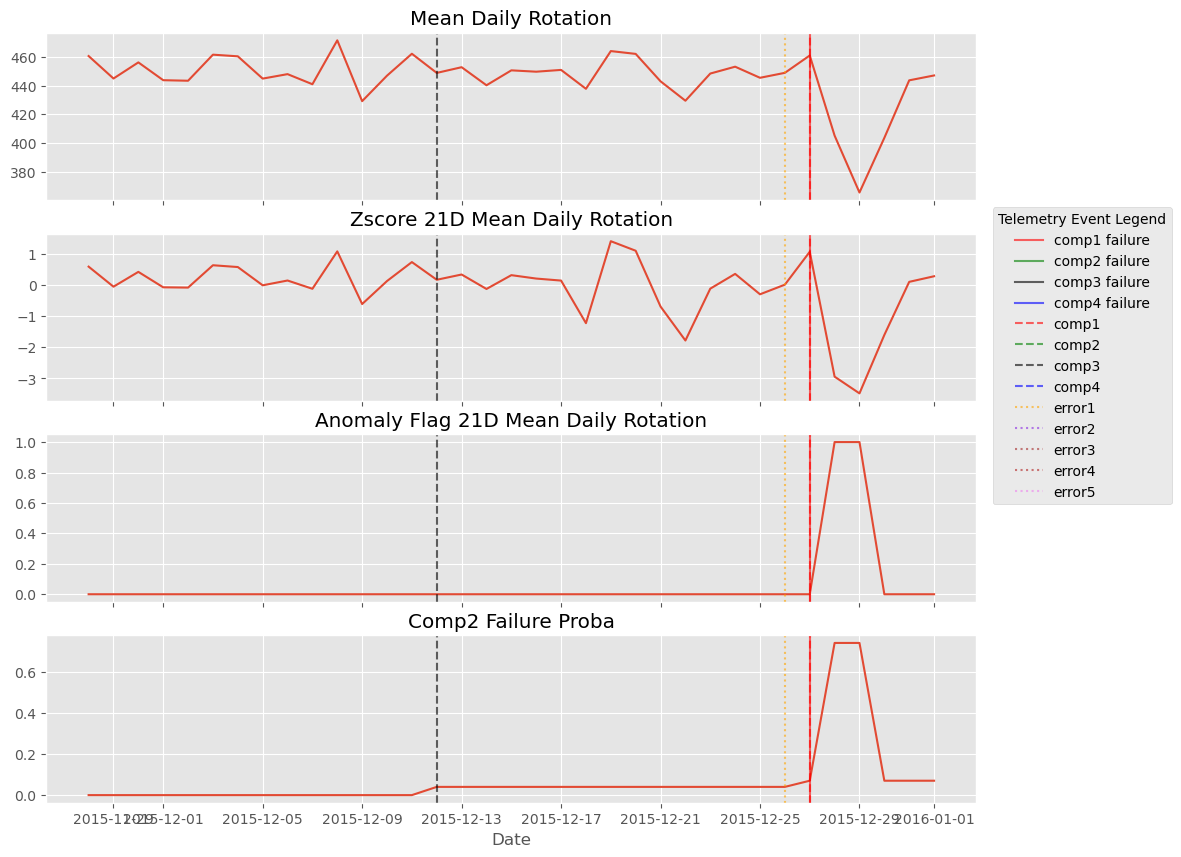

In [38]:
plot_columns=["mean_daily_rotation",
              "zscore_21d_mean_daily_rotation",
              "anomaly_flag_21d_mean_daily_rotation",
              "comp2_failure_proba"
             ]
plot_df= (
    validation_analysis_df
    .filter(pl.col("component_instance_id")=="17-comp2-8")
)

plot_timeseries_stacked(plot_df.to_pandas(),plot_columns)

### Component 1 Voltage Model Example

The plot below illustrates the **Cox Proportional Hazards (PH) model** applied to **Component 1**, where the time-varying predictor is the **voltage anomaly flag**.

The bottom panel shows the model’s estimated **daily failure probability** for a single component instance over its operating life. Key observations:

- **Early anomaly (September):**  
  An anomaly flag occurs early in the component's life, but its impact on failure probability is minimal because the Cox PH model accounts for **baseline risk accumulation over time**, which is still very low at this stage.

- **Mid-life anomaly (November):**  
  A second anomaly flag appears later in the operating cycle, causing a more noticeable increase in predicted failure probability. This reflects the interaction between **baseline operating risk** and **anomaly signals**.

- **Late-life anomaly (December):**  
  A final anomaly occurs after the component has accumulated significant runtime, leading to a dramatic spike in predicted failure probability. The model approaches **near certainty of failure within 2 days**, which aligns closely with the actual observed failure event.

This example reinforces the model’s capability to combine **time-dependent baseline risk** with **real-time anomaly detection**, prioritizing late-life anomalies as strong indicators of imminent failure.


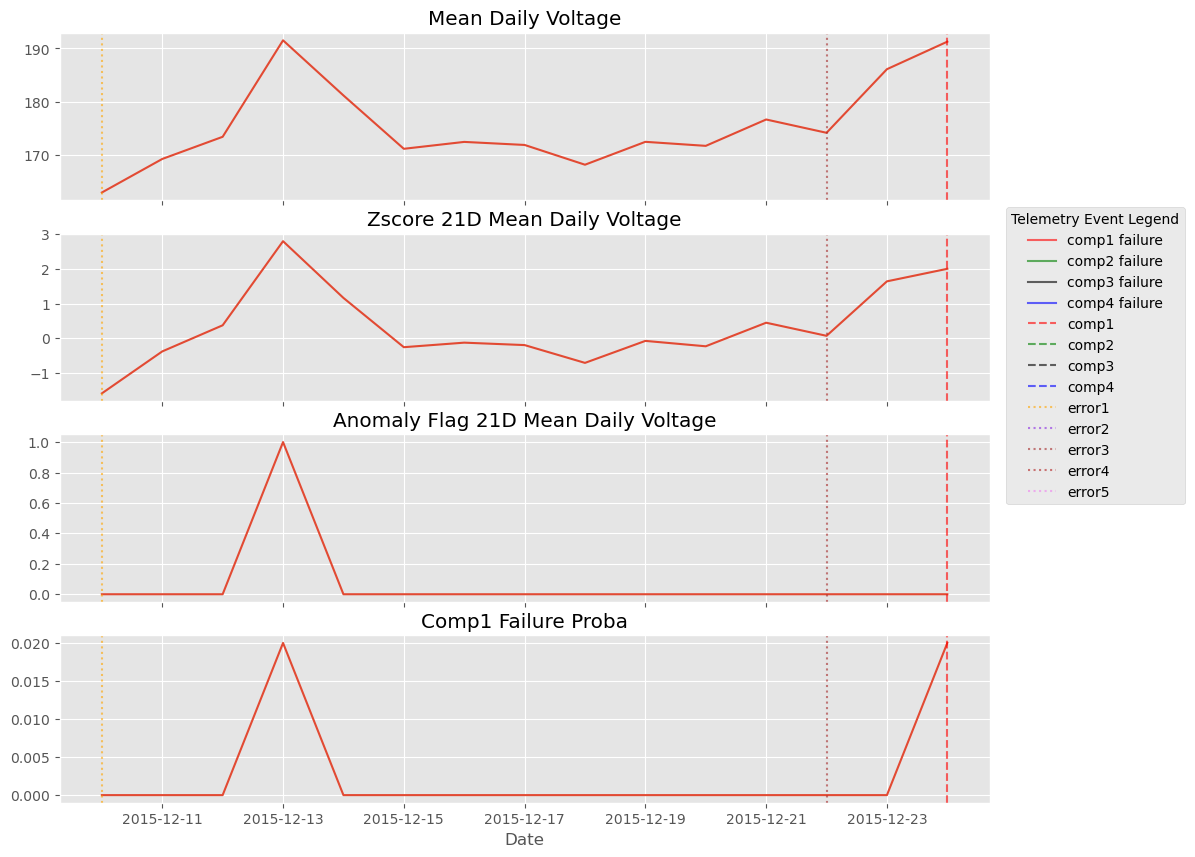

In [39]:
plot_columns=["mean_daily_voltage",
              "zscore_21d_mean_daily_voltage",
              "anomaly_flag_21d_mean_daily_voltage",
              "comp1_failure_proba"
             ]
plot_df= (
    validation_analysis_df
    .filter(pl.col("component_instance_id")=="19-comp1-10")
)

plot_timeseries_stacked(plot_df.to_pandas(),plot_columns)

### Why This Model Works and How to Deploy It

The **Cox Proportional Hazards model with time-varying covariates** is an interpretable tool for predictive maintenance. Unlike black-box models, Cox PH provides clear hazard ratios that explain how different factors can influence failure risk over time. This interpretability is crucial for operational teams who need both accurate predictions and actionable insights they can trust. By combining **baseline operating risk** with **real-time anomaly detection**, the model dynamically adjusts failure probabilities, ensuring late life anomalies are treated as urgent while early anomalies are deprioritized.

Data teams can deploy this seamlessly within existing **Python-based workflows** using libraries like `lifelines` for survival modeling, `pandas`/`polars` for data handling, and automation frameworks such as **Airflow**. Model outputs,such as failure probabilities and ranked risk lists can be integrated into dashboards (e.g., Power BI, Streamlit, or custom web apps) or pushed into alerting systems. This allows maintenance teams to **prioritize interventions**, focusing resources on the highest-risk machines. As demonstrated with the **PdM Azure dataset**, this approach can transform raw sensor data into actionable intelligence, reducing downtime and optimizing maintenance schedules.
